In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap08/input/data-salary-2.txt')
df.head()

,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


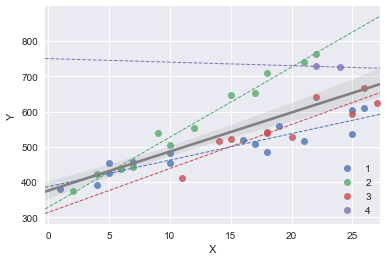

In [3]:
plt.figure()
for KID, df_sub, in df.groupby(by="KID"):
    sns.regplot(x=df_sub.X, y=df_sub.Y, label=KID, 
                ci=0, line_kws={"linestyle":"--", "linewidth":1.0})
sns.regplot(x=df.X, y=df.Y, scatter=False, ci=95, line_kws={"color":"gray"})
plt.legend()
plt.show()

## グループごとに切片と傾きを持つ場合

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma )$

In [4]:
model_code="""
data {
  int N;
  int K;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real a[K];
  real b[K];
  real<lower=0> sigma;
}
model {
  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], sigma);
}
generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(a[KID[n]]+b[KID[n]]*X[n], sigma);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], K=df.KID.nunique(), X=df.X, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_83e0e64862a58666285f87823abf6106 NOW.


Inference for Stan model: anon_model_83e0e64862a58666285f87823abf6106.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0]       387.15    0.29  14.45 358.65 377.17 387.29 396.89 415.75   2472    1.0
a[1]       328.91    0.31  17.11 295.97 317.33 328.93 340.35  363.0   3033    1.0
a[2]       313.77    0.71  34.14 246.92 290.71 314.16 336.65 383.78   2323    1.0
a[3]        748.8    3.01 158.97 437.27 645.05 749.37 855.88 1059.3   2792    1.0
b[0]         7.51    0.02   0.89   5.71   6.92   7.52   8.12   9.24   2587    1.0
b[1]        19.84    0.02   1.27  17.34  19.01  19.84  20.68  22.32   3112    1.0
b[2]        12.47    0.04   1.69   9.09  11.33  12.45  13.57  15.81   2331    1.0
b[3]        -0.95    0.12   6.39  -13.5  -5.13   -1.0   3.31  11.65   2774    1.0
sigma       27.36    0.07   3.64   21.3  24.76  27.03  29.58  35.47   263

## ベイズ信頼区間

C:\Users\eX\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


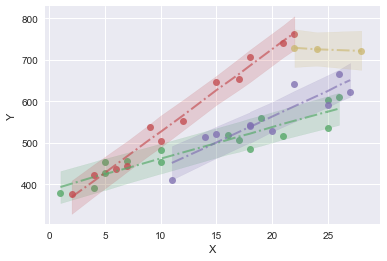

In [5]:
ms = fit.extract()

conf=[10, 50, 90]

qua = np.percentile(ms['y_pred'], q=conf, axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in conf])
df_pred = df.join(d_qua)

palette = sns.color_palette("deep", 10)
for KID, df_sub in df_pred.groupby(by='KID'):
    df_sub.sort_values(by=['X'], inplace=True)
    sns.regplot(x='X', y='Y', data=df_sub, fit_reg=False, color=palette[KID])
    plt.plot(df_sub.X, df_sub.p50, '-.', color=palette[KID], lw=2.0, alpha=2/3)
    plt.fill_between(df_sub.X, df_sub.p10, df_sub.p90, alpha=.2, color=palette[KID])

## 階層モデル

$a[k]$ ~ $ Normal(a_{avg}, \sigma_a)$

$b[k]$ ~ $ Normal(b_{avg}, \sigma_b)$

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma )$

$k = 1, ..., K$

$n = 1, ..., N$

In [6]:
model_code="""
data {
  int N;
  int K;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real a0;
  real b0;
  real a[K];
  real b[K];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_y;
}
model {
  for (k in 1:K) {
    a[k] ~ normal(a0, s_a);
    b[k] ~ normal(b0, s_b);  
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], s_y);
}
generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(a[KID[n]]+b[KID[n]]*X[n], s_y);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], K=df.KID.nunique(), X=df.X, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_776fcf10aa8956927b60d3c3a6c0ed59 NOW.


## ベイズ信頼区間

C:\Users\eX\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


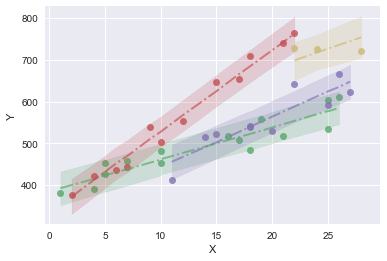

In [7]:
ms = fit.extract()

conf=[10, 50, 90]

qua = np.percentile(ms['y_pred'], q=conf, axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in conf])
df_pred = df.join(d_qua)

palette = sns.color_palette("deep", 10)
for KID, df_sub in df_pred.groupby(by='KID'):
    df_sub.sort_values(by=['X'], inplace=True)
    sns.regplot(x='X', y='Y', data=df_sub, fit_reg=False, color=palette[KID])
    plt.plot(df_sub.X, df_sub.p50, '-.', color=palette[KID], lw=2.0, alpha=2/3)
    plt.fill_between(df_sub.X, df_sub.p10, df_sub.p90, alpha=.2, color=palette[KID])